Given our target variable ('total_cost') is a continuous variable, this is a regression problem. 

Here's a simplified step-by-step guide using Python and scikit-learn, a popular machine learning library:

1. Data Preprocessing:
    - Handle missing values: Check and handle missing values in your dataset.
    - Encode categorical variables: Convert categorical variables into numerical format, as most machine learning models require numerical input.
    
2. Feature Selection:
    - Identify relevant features: Select features that are likely to have an impact on predicting 'total_cost.'
    
3. Split the Data:
    - Split your dataset into a training set and a testing set. The training set is used to train the model, and the testing set is used to evaluate its performance.

4. Build a Model:
    - Choose a regression algorithm: Common choices include Linear Regression, Decision Trees, Random Forest, Gradient Boosting, or Support Vector Machines.
    - Train the model using the training data.

5. Evaluate the Model:
    - Use the testing set to evaluate the model's performance.
    - Common evaluation metrics for regression include Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared.

6. Tune and Improve:
    - If the model performance is not satisfactory, you may need to fine-tune hyperparameters or try different algorithms.
    - Feature engineering: Experiment with creating new features or transforming existing ones to improve model performance.


# Importing Libraries

In [306]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the cleaned dataset

In [214]:
df_train = pd.read_csv('data/savegame.csv')
df_test  = pd.read_csv('data/Test.csv')

# Create a pipeline

### Seperate numerical and categorical features

In [297]:
#num_features = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar', 'night_total', 'number_travelers']
num_features = ['night_total', 'number_travelers']
#num_features = df_train.select_dtypes('number')
cat_features = list(set(df_train.columns) - set(num_features) - set(('total_cost', 'total_cost_euro')))

### Setup Target and Features

In [298]:
y_train = df['total_cost_euro']
X_train = df[num_features + cat_features]

### Building the pipeline

In [248]:
# Create transformers for numerical and categorical features
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Create a pipeline with the preprocessor and a regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'regressor': [
        LinearRegression(), 
        Ridge(alpha=0.5), 
        DecisionTreeRegressor(), 
        RandomForestRegressor(), 
#        XGBRegressor()
    ],
}

# Create GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................regressor=LinearRegression(); total time=   0.1s
[CV] END .......................regressor=LinearRegression(); total time=   0.1s
[CV] END .......................regressor=LinearRegression(); total time=   0.1s
[CV] END .......................regressor=LinearRegression(); total time=   0.1s
[CV] END .......................regressor=LinearRegression(); total time=   0.1s
[CV] END .........................regressor=Ridge(alpha=0.5); total time=   0.0s
[CV] END .........................regressor=Ridge(alpha=0.5); total time=   0.1s
[CV] END .........................regressor=Ridge(alpha=0.5); total time=   0.1s
[CV] END .........................regressor=Ridge(alpha=0.5); total time=   0.0s
[CV] END .........................regressor=Ridge(alpha=0.5); total time=   0.0s
[CV] END ..................regressor=DecisionTreeRegressor(); total time=   0.1s
[CV] END ..................regressor=DecisionTree

# Evaluate the best Model

In [309]:
# Evaluate the best model
print('Best Model:', best_model.named_steps['regressor'])
print('Mean Absolute Percentage Error:', round(mean_absolute_percentage_error(y_test, y_pred_test), 2))
print('Mean Absolute Error:', round(np.sqrt(mean_absolute_error(y_test, y_pred_test)), 2))
print('Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2))
print('R-squared:', round(r2_score(y_test, y_pred_test), 2))








def coeff_info(model):
    coeff_used = np.sum(model.coef_!=0)
    print('The model is using', coeff_used, 'out of 66 features.')
    print( "The highest coefficient has a value of:", max(model.coef_.round(3)))

    
#coeff_info(best_model)

Best Model: RandomForestRegressor()
Mean Absolute Percentage Error: 1.0
Mean Absolute Error: 2789.32
Mean Squared Error: 14200321.58
R-squared: -0.43


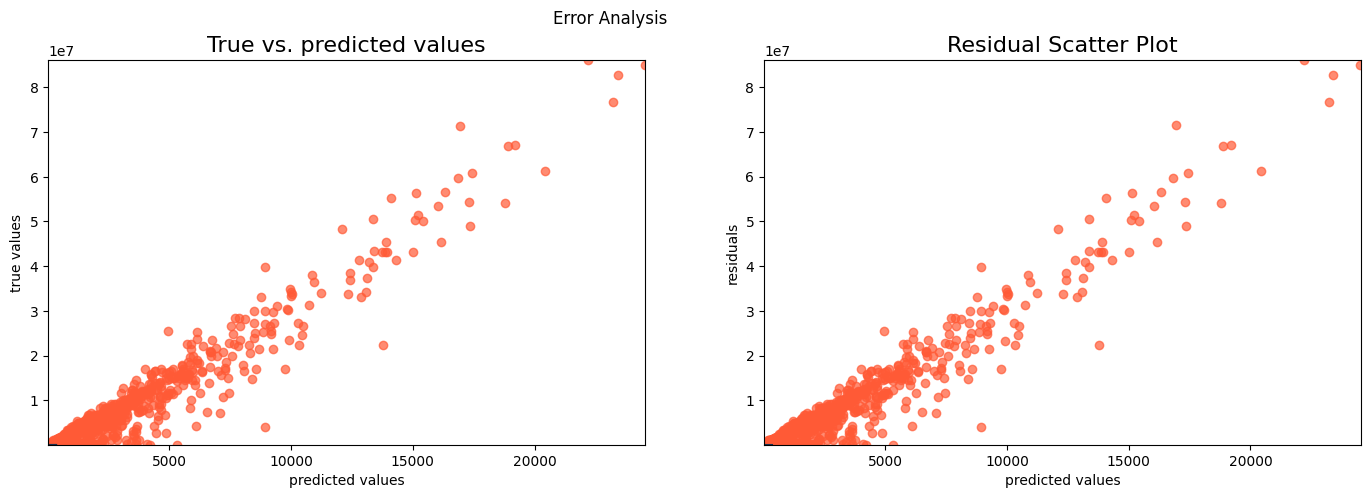

In [310]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10))
    
error_analysis(y_test, y_pred_test)

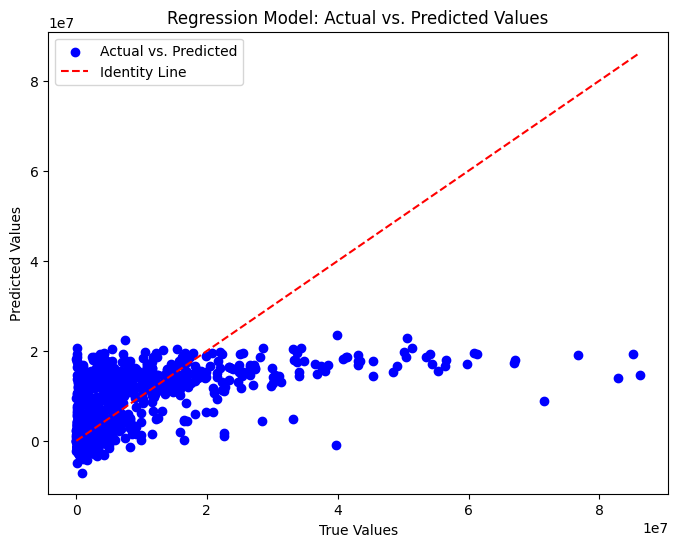

In [311]:

# Plotting the results
plt.figure(figsize=(8, 6))

# Scatter plot of true vs. predicted values
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')

# Plot the identity line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Identity Line')

plt.title('Regression Model: Actual vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Saving the model

In [265]:
from scripts.model_serializer import ModelSerializer

best_model_serializer = ModelSerializer('models/best_model.sav')
best_model_serializer.dump(best_model)

# Loading the model

In [266]:
serializer = ModelSerializer('models/best_model.sav')
best_model = serializer.load()
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['night_total',
                                                   'number_travelers']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['purpose',
                                                   'tour_arrangement',
                                                   'package_foo...
                                                   'package_guided_tour',
                                                   'most_impressing',
                                                   'single_female',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'main_activity',
                                                   'total_male', 'info_source',
                                                   'age_group',
                                                   'package_transport_int',
                                                   'total_female',
                                                   'package_accomodation',
                                                   'single_male',
                                                   'payment_mode', 'country',
                                                   'package_transport_tz',
                                                   'first_trip_tz',
                                                   'package_sightseeing'])])),
                ('regressor', RandomForestRegressor())])

In this example:

The ColumnTransformer is used to apply different transformations to numerical and categorical features separately.
The Pipeline includes both preprocessing steps and the regression model.
Numerical features are imputed with the mean and scaled using StandardScaler.
Categorical features are imputed with the most frequent value and one-hot encoded using OneHotEncoder.
This pipeline allows for a cleaner and more organized approach to data preprocessing and model building. Adjust the column names and other parameters based on your specific dataset and requirements.
